# Risques de cancer cervical - partie : Préparation
par Binh Minh TRAN

## 1. Importation des packages nécessaires

In [1]:
import numpy as np  
import pandas as pd  
#Gestion des fichiers et du système  
import os  # Interaction avec le système de fichiers  
import sys  # Gestion des chemins et des arguments système  
from pathlib import Path  # Manipulation avancée des chemins de fichiers  
#Visualisation des données  
import matplotlib.pyplot as plt
import seaborn as sns  
import plotly.express as px
# Validation croisée en k-fold et diviser dataset  
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# Sauvegarde et chargement des objets  
import pickle  
#
from collections import Counter

## 2. Télechargement le data set

In [2]:
base_dir = os.path.dirname(os.path.abspath(sys.argv[1]))
file_path = os.path.join(base_dir, "..\Data\sobar-72.csv")  
raw_path = Path(file_path)
corrected_path = raw_path.resolve()
print("Base directory:", base_dir)
print("File path:", file_path)
print("corrected path:", corrected_path)
df = pd.read_csv(corrected_path)

Base directory: C:\Users\minhm\OneDrive - Université Côte d'Azur\BUT SD\BUT 24-25\AI project\Project\Code
File path: C:\Users\minhm\OneDrive - Université Côte d'Azur\BUT SD\BUT 24-25\AI project\Project\Code\..\Data\sobar-72.csv
corrected path: C:\Users\minhm\OneDrive - Université Côte d'Azur\BUT SD\BUT 24-25\AI project\Project\Data\sobar-72.csv


## 3. EDA (Analyse Exploratoire des Données)

In [3]:
df.head()

,behavior_sexualRisk,behavior_eating,behavior_personalHygine,intention_aggregation,intention_commitment,attitude_consistency,attitude_spontaneity,norm_significantPerson,norm_fulfillment,perception_vulnerability,perception_severity,motivation_strength,motivation_willingness,socialSupport_emotionality,socialSupport_appreciation,socialSupport_instrumental,empowerment_knowledge,empowerment_abilities,empowerment_desires,ca_cervix
0,10,13,12,4,7,9,10,1,8,7,3,14,8,5,7,12,12,11,8,1
1,10,11,11,10,14,7,7,5,5,4,2,15,13,7,6,5,5,4,4,1
2,10,15,3,2,14,8,10,1,4,7,2,7,3,3,6,11,3,3,15,1
3,10,11,10,10,15,7,7,1,5,4,2,15,13,7,4,4,4,4,4,1
4,8,11,7,8,10,7,8,1,5,3,2,15,5,3,6,12,5,4,7,1


In [4]:
print(f"La dimension de DataFrame: {df.shape}")

La dimension de DataFrame: (72, 20)


In [5]:
# Nombre d'individus positifs au Ca Cervix
nombre_cervical_positif = (df.iloc[:, -1] == 1).sum()
print(f"Nombre d'individus positifs au Ca Cervix : {nombre_cervical_positif} ( {nombre_cervical_positif/df.shape[0]} %)")

# Nombre d'individus négatifs au Ca Cervix
nombre_cervical_negatif = (df.iloc[:, -1] == 0).sum()
print(f"Nombre d'individus négatifs au Ca Cervix : {nombre_cervical_negatif} ( {nombre_cervical_negatif/df.shape[0]} %)")

Nombre d'individus positifs au Ca Cervix : 21 ( 0.2916666666666667 %)
Nombre d'individus négatifs au Ca Cervix : 51 ( 0.7083333333333334 %)


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   behavior_sexualRisk         72 non-null     int64
 1   behavior_eating             72 non-null     int64
 2   behavior_personalHygine     72 non-null     int64
 3   intention_aggregation       72 non-null     int64
 4   intention_commitment        72 non-null     int64
 5   attitude_consistency        72 non-null     int64
 6   attitude_spontaneity        72 non-null     int64
 7   norm_significantPerson      72 non-null     int64
 8   norm_fulfillment            72 non-null     int64
 9   perception_vulnerability    72 non-null     int64
 10  perception_severity         72 non-null     int64
 11  motivation_strength         72 non-null     int64
 12  motivation_willingness      72 non-null     int64
 13  socialSupport_emotionality  72 non-null     int64
 14  socialSuppor

In [7]:
print(df.columns)

Index(['behavior_sexualRisk', 'behavior_eating', 'behavior_personalHygine',
       'intention_aggregation', 'intention_commitment', 'attitude_consistency',
       'attitude_spontaneity', 'norm_significantPerson', 'norm_fulfillment',
       'perception_vulnerability', 'perception_severity',
       'motivation_strength', 'motivation_willingness',
       'socialSupport_emotionality', 'socialSupport_appreciation',
       'socialSupport_instrumental', 'empowerment_knowledge',
       'empowerment_abilities', 'empowerment_desires', 'ca_cervix'],
      dtype='object')


#### On change le nom des attributs pour les intégrer au projet basé en français.

In [8]:
df = df.rename(columns={
    'behavior_sexualRisk': 'comportement_risqueSexuel',
    'behavior_eating': 'comportement_alimentation',
    'behavior_personalHygine': 'comportement_hygienePersonnelle',
    
    'intention_aggregation': 'intention_aggrégation',
    'intention_commitment': 'intention_engagement',
    
    'attitude_consistency': 'attitude_cohérence',
    'attitude_spontaneity': 'attitude_spontanéité',
    
    'norm_significantPerson': 'norme_personneImportante',
    'norm_fulfillment': 'norme_accomplissement',
    
    'perception_vulnerability': 'perception_vulnérabilité',
    'perception_severity': 'perception_sévérité',
    
    'motivation_strength': 'motivation_force',
    'motivation_willingness': 'motivation_volonté',
    
    'socialSupport_emotionality': 'soutienSocial_émotionnel',
    'socialSupport_appreciation': 'soutienSocial_appréciation',
    'socialSupport_instrumental': 'soutienSocial_instrumental',
    
    'empowerment_knowledge': 'autonomisation_connaissance',
    'empowerment_abilities': 'autonomisation_compétences',
    'empowerment_desires': 'autonomisation_désirs',
    
    'ca_cervix': 'cancer_colUterus'
})

#### Maintenant, on va comparer 2 groupes (positif et négatif au Ca Cervix)

In [9]:
groupe_positif = df[(df.iloc[:, -1] == 1)]
groupe_negatif = df[(df.iloc[:, -1] == 0)]

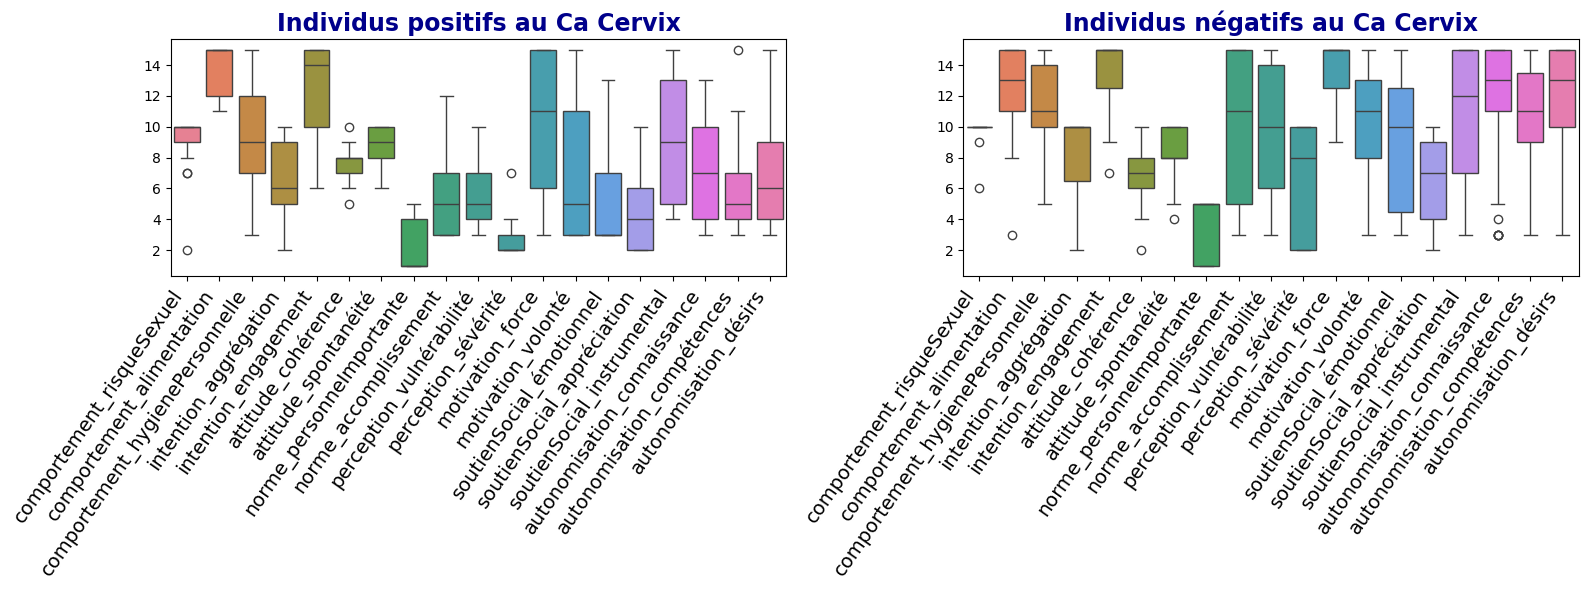

In [10]:
# Création d'une figure avec 2 sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 ligne, 2 colonnes

# Boxplot pour les individus positifs
sns.boxplot(data=groupe_positif.iloc[:, :-1], ax=axes[0])  
axes[0].set_title("Individus positifs au Ca Cervix",fontsize=17, fontweight='bold', color='darkblue')

# Boxplot pour les individus négatifs
sns.boxplot(data=groupe_negatif.iloc[:, :-1], ax=axes[1])  
axes[1].set_title("Individus négatifs au Ca Cervix",fontsize=17, fontweight='bold', color='darkblue')

# Ajuster la rotation et l'alignement des étiquettes de l'axe X
for ax in axes:
    ax.tick_params(axis='x', labelsize=14)
    for label in ax.get_xticklabels():
        label.set_rotation(55)
        label.set_horizontalalignment('right')


plt.tight_layout()
plt.savefig('../Image/boxplot_ca_cervix.png')
plt.show()

Selon le boxplot des attributs entre les deux groupes (positif et négatif au Ca Cervix), les scores des comportements d'hygiène personnelle dans le groupe négatif ont tendance à être plus élevés que dans le groupe positif. Les personnes négatives au Ca Cervix obtiennent des scores plus élevés dans des déterminants tels que l'automatisation, le soutien social, la perception et la norme, comparativement à l'autre groupe. En général, les scores des comportements et de leurs déterminants dans le groupe négatif sont décalés vers la droite, ce qui indique des valeurs plus élevées. Nous remarquons que l'échelle de la plupart des variables atteint un maximum de 15 points. Cependant, la variable "risque sexuel" a un maximum de 10 points, ce qui suggère soit qu'elle constitue une exception, soit qu'elle suit également une échelle sur 15 points, mais qu'aucun individu n'a dépassé le seuil de 10.

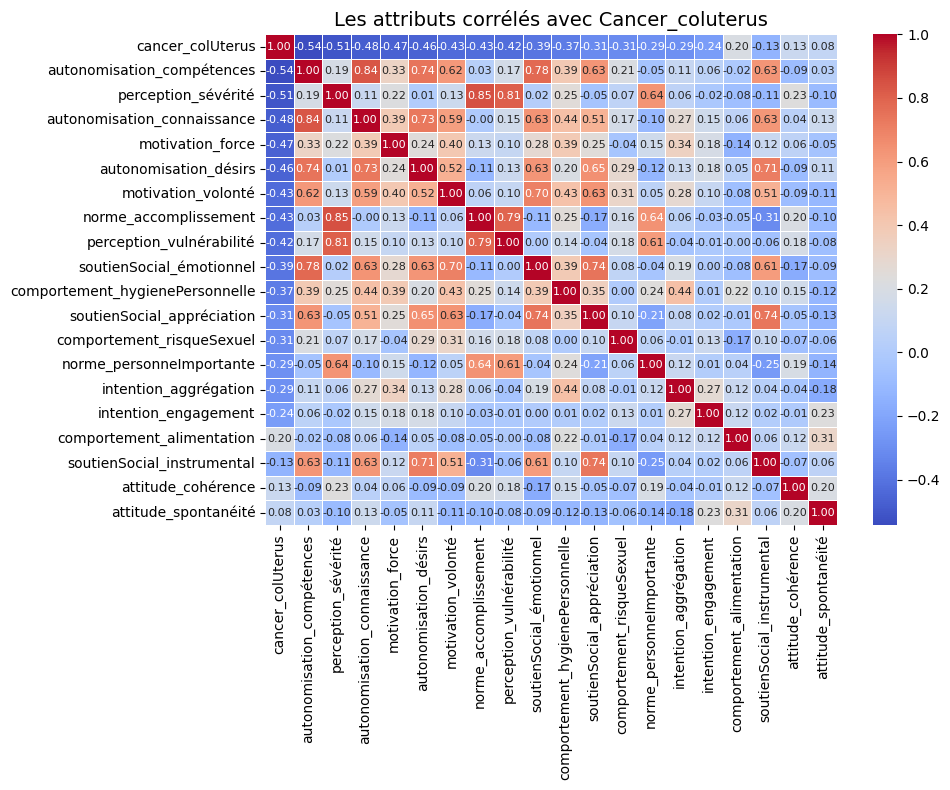

In [11]:
target = "cancer_colUterus"

# Calcul de la matrice de corrélation pour les colonnes numériques
corr = df.select_dtypes(include=np.number).corr()

# Sélectionner toutes les variables corrélées avec la variable cible (y compris la cible elle-même)
x = corr[target].abs().sort_values(ascending=False).index  # Trier les variables par corrélation avec la cible
corr_df = df[x]  # Créer un DataFrame contenant uniquement les variables corrélées

# Calcul de la matrice de corrélation entre les variables sélectionnées
corr_matrix = corr_df.corr()

# Créer une heatmap 
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, linewidths=0.5,annot_kws={'size': 8})


plt.title(f"Les attributs corrélés avec {target.capitalize()}", fontsize=14)

plt.tight_layout()
plt.savefig("../Image/matrice_corrélation.png")
plt.show()

Évidemment, les trois comportements principaux ne sont pas nécessairement corrélés entre eux. Toutefois, les déterminants 'autonomisation compétences' et 'autonomisation connaissances' présentent un coefficient de corrélation élevé, car ils sont souvent liés à l'acquisition de compétences et de connaissances dans des contextes similaires. De même, 'perception de vulnérabilité' et 'perception de la sévérité' montrent une forte corrélation, car elles concernent la manière dont une personne évalue son propre risque face à une situation donnée. Ces deux variables, 'perception de vulnérabilité' et 'perception de la sévérité', sont également corrélées avec la norme d'accomplissement, car une perception élevée de la vulnérabilité et de la sévérité incite généralement les individus à adopter des comportements qui sont perçus comme socialement acceptables et conformes aux attentes des normes sociales, ce qui influence leur prise de décision.

##  4. Diviser le jeu de données pour entraîner et tester

Nous choisissons de diviser les données de manière stratifiée afin de garantir que l’ensemble d’entraînement reflète fidèlement la distribution des deux catégories. Le découpage est réalisé selon un ratio de 60 % pour l’entraînement et 40 % pour le test, assurant ainsi que le test set dispose d’un volume suffisant de données car notre dataset n'est pas grand, notamment dans le cas où les classes sont déséquilibrées, évitant ainsi un accuracy artificiellement élevé pouvant atteindre 1.

Les 60 % de données d’entraînement seront ensuite utilisés pour effectuer une validation croisée, permettant d’optimiser les hyperparamètres du modèle. Une fois ces derniers déterminés, nous réentraînerons le modèle sur ces mêmes 60 % de données en utilisant les meilleurs hyperparamètres trouvés. Enfin, nous évaluerons la performance finale du modèle sur les 40 % restants (test set), qui n’auront jamais été utilisés durant l'entraînement ni l’optimisation, garantissant ainsi une estimation plus fiable de sa capacité de généralisation.

In [12]:
X= df.drop(["cancer_colUterus"], axis=1)
y= df["cancer_colUterus"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=28,stratify=y)
print(X_train.shape)
print(X_test.shape)

(43, 19)
(29, 19)


In [13]:
print("La distribution des classes dans l'ensemble d'entraînement", Counter(y_train))

La distribution des classes dans l'ensemble d'entraînement Counter({0: 30, 1: 13})


## 5. Équilibre des données d'entraînement

On applique SMOTE afin de générer des points de données « artificiels » en trouvant les voisins des données du groupe minoritaire avec la taille du ratio de rééchantillonnage de 100% ( les 2 groupes ont la taille égale )

In [14]:
smote = SMOTE(random_state=20, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)

(60, 19)
(60,)


In [15]:
print("La distribution des classes dans l'ensemble d'entraînement Après SMOTE:", Counter(y_train_smote))

La distribution des classes dans l'ensemble d'entraînement Après SMOTE: Counter({0: 30, 1: 30})


## 6. Exporter les datasets 

On sauvegarde les training sets et test sets pour chaque fold afin de pouvoir les récupérer lors du processus d'entraînement. Cela permet d'utiliser les mêmes données pour différents modèles.

In [16]:
with open('Variables/variables.pkl', 'wb') as f:
    pickle.dump((df, X_train, X_test, y_train, y_test,X_train_smote, y_train_smote), f)

print("Les données ont été enregistrées avec succès dans 'variables.pkl'.")

Les données ont été enregistrées avec succès dans 'variables.pkl'.
